The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Relative L2 error: 1.0574e+01


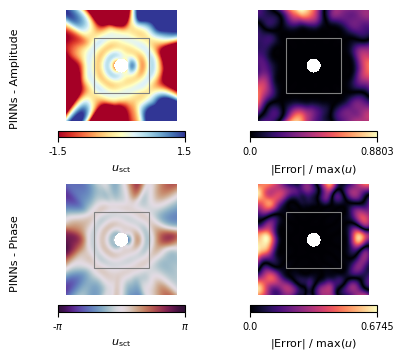

In [3]:
# utf-8
# reload kernel
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import os
import numpy as np
from scipy.interpolate import griddata

# Set the current directory and utilities path
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utilities')

# Change the working directory to the notebook's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

# Import Functions
from analytical_solution_functions import sound_hard_circle_calc 
from analytical_solution_functions import mask_displacement
from pinns_solution_functions import plot_pinns_displacements
from pinns_solution_functions import initialize_and_load_model
from pinns_solution_functions import predict_displacement_pinns 
from pinns_solution_functions import process_displacement_pinns

r_i = np.pi/4 # Inner radius
l_se = 2*np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 2*501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]


# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)


# Parameters
n_Omega_P = 10_000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 250          # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4          # Inner radius
l_e = 2*np.pi              # Length of the semi-edge of the square
k = 3.0                  # Wave number
iter = 0                 # Iteration counter
side_length = 2 * l_e    # Side length of the square
 
# Initialize and load the model
model_path = 'models/Scattering_2_75.pt'
model = initialize_and_load_model(model_path)

# Predict the displacement
u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(model, l_e, r_i, k, n_grid)

# Example usage
u_sc_amp_pinns,u_sc_phase_pinns,u_amp_pinns, u_phase_pinns, diff_uscn_amp_pinns, diff_u_scn_phase_pinns = process_displacement_pinns(
    model, l_e, r_i, k, n_grid, X, Y, R_exact, u_scn_exact
)

"""
Compute relative L2 error (real part of scattered field)
"""

# Create masked copies to zero-out interior region
R_grid = np.sqrt(X**2 + Y**2)
u_scn_exact_masked = np.copy(u_scn_exact)
u_scn_amp_masked   = np.copy(u_sc_amp_pinns)
u_scn_exact_masked[R_grid < r_i] = 0
u_scn_amp_masked[R_grid < r_i] = 0

relative_error = np.linalg.norm(u_scn_exact_masked.real - u_scn_amp_masked.real, 2) / \
                 np.linalg.norm(u_scn_exact_masked.real, 2)
print(f"Relative L2 error: {relative_error:.4e}")

plot_pinns_displacements(
    X, Y,
    u_sc_amp_pinns,
    np.real(u_inc_exact) + u_sc_amp_pinns,
    np.abs(np.real(u_scn_exact) - u_sc_amp_pinns),
    u_sc_phase_pinns,
    u_sc_phase_pinns + np.real(u_inc_exact),
    np.abs(np.imag(u_scn_exact) - u_sc_phase_pinns)
)
